# House Prices - Advanced Regression Techniques

* [1. Импортируем библиотеки](#1-bullet)
* [2. Читаем файлы, соединяем в один.](#2-bullet)
* [3. Распределение цены.](#3-bullet)
* [4. Удаляем признак ID у обучающей и валидационной выборки и делаем предварительное обучение.](#4-bullet)
* [5. Производим кластеризцию по числовым признакам.](#5-bullet)
* [6. Производим разбиение признаков качества](#6.-bullet)
* [7. Заполняем пропуски и применяем OneHotEncoding.](#7-bullet)
* [8. Делим датасет на обучающий и валидационный.](#8-bullet)
* [9. Определяем признаки и целевую переменную.](#9-bullet)
* [10. Нормализуем данные.](#10-bullet)
* [11. Модель № 1: RandomForestRegressor.](#11-bullet)
* [12. Модель № 2: XGBRegressor.](#12-bullet)
* [13. Модель № 3: LGBMRegressor.](#13-bullet)
* [14. Модель № 4: CatBoostRegressor.](#14-bullet)
* [15. Смотрим какие признаки внесли наибольшее вияние.](#15-bullet)
* [16. Выбираем лучшую модель и сохраняем в новый файл.](#16-bullet)

# Импортируем библиотеки.<a class="anchor" id="1-bullet"></a>

In [3]:
!pip install sklearn

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN, AgglomerativeClustering
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from IPython.display import Image
from umap import UMAP
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier

In [59]:
def concat(train_data, test_data):
    ''' Функция соединяет несколько датасетов в один. '''
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def second_concat(train_data, test_data):
    ''' Фукция соединяет числовой и строковый датасеты. '''
    return pd.concat([train_data, test_data], axis=1, sort=True).reset_index(drop=True)

def separate(all_data):
    ''' Функция разделяет датасет на обучающий и валидационный. '''
    return all_data.loc[:1459], all_data.loc[1460:].drop(['SalePrice'], axis=1)

In [60]:
def fill_empty(df):
    ''' Функция заполняет пропуски в датасете. '''
    for i in df.columns:
        if df[i].dtype == 'O':
            df[i] = df[i].fillna('missed')
        else:
            df[i] = df[i].fillna(0) 
    return df

In [61]:
def OneHotEncoding(df):
    ''' Функция производит Encoding. '''
    for i in df.columns:
        if df[i].dtype == 'O' and i != 'SalePrice':
            df = pd.concat([df, pd.get_dummies(df[i], prefix=(i + 'M'))], axis=1)
            df.drop(i, axis=1, inplace=True)
    return df

# Читаем файлы, соединяем в один.<a class="anchor" id="2-bullet"></a>

In [251]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Распределение цены.<a class="anchor" id="3-bullet"></a>

C:\Users\ryzhk\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


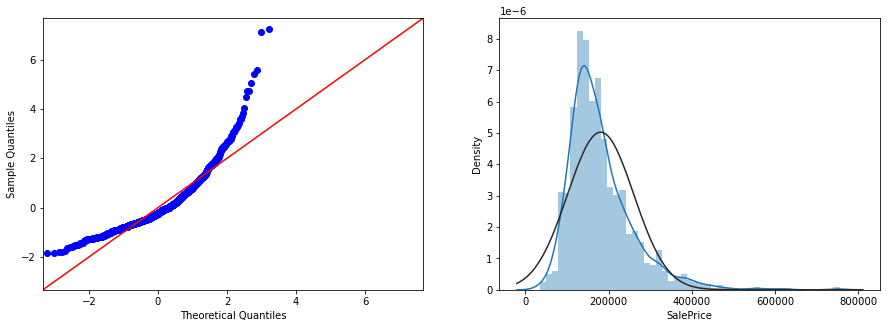

In [252]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sm.qqplot(df_train.SalePrice, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(df_train.SalePrice, kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

### Логарифмируем 

C:\Users\ryzhk\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


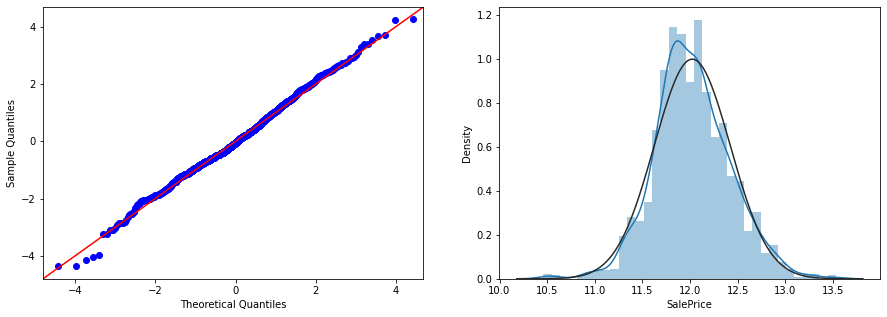

In [253]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sm.qqplot(np.log(df_train.SalePrice ), stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(np.log(df_train.SalePrice), kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

## Удаляем признак ID у обучающей и валидационной выборки и делаем предварительное обучение.<a class="anchor" id="4-bullet"></a>

In [254]:
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [255]:
df_number_train = df_train.select_dtypes(exclude=[object])
df_str_train = df_train.select_dtypes(include=[object])
df_number_test = df_test.select_dtypes(exclude=[object])
df_str_test = df_test.select_dtypes(include=[object])

In [256]:
'''Добавляем возраст дома, сколько лет прошло с момента последнего ремонта и суммируем доступные площади'''
df_number_train['House_age'] = 2021 - df_number_train.YearBuilt
df_number_train['Remod_age'] = 2021 - df_number_train.YearRemodAdd
df_number_train['Sold_age'] = 2021 - df_number_train.YrSold
df_number_house_train = df_number_train[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF',
                           '2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']]
df_number_train['house_sum'] = df_number_house_train.sum(axis=1)

df_number_test['House_age'] = 2021 - df_number_test.YearBuilt
df_number_test['Remod_age'] = 2021 - df_number_test.YearRemodAdd
df_number_test['Sold_age'] = 2021- df_number_test.YrSold
df_number_house_test = df_number_test[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF',
                            '2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']]
df_number_test['house_sum'] = df_number_house_test.sum(axis=1)

<ipython-input-256-28e5ec3d1fd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_number_train['House_age'] = 2021 - df_number_train.YearBuilt
<ipython-input-256-28e5ec3d1fd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_number_train['Remod_age'] = 2021 - df_number_train.YearRemodAdd
<ipython-input-256-28e5ec3d1fd0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [257]:
target = 'SalePrice'
df_number_train = fill_empty(df_number_train)
df_number_test = fill_empty(df_number_test)

<ipython-input-60-f8b7897f2bc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].fillna(0)


In [258]:
df_train_X_pre = df_number_train.drop('SalePrice', axis=1)
df_train_Y_pre = df_number_train[target]

X_pre, Y_pre = df_train_X_pre.to_numpy(), df_train_Y_pre.to_numpy()
Y_pre = np.log(Y_pre)
X_test_pre = df_number_test.to_numpy()

xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=3,
                       gamma=0,
                       colsample_bytree=0.7,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       objective='reg:squarederror')
model_pre = xgboost.fit(X_pre, Y_pre)
print('R2= ', r2_score(Y_pre, xgboost.predict(X_pre)))
Final_XGBR_pre = np.exp(xgboost.predict(X_test_pre))

df_number_test['SalePrice'] = Final_XGBR_pre

R2=  0.9718345260266967


<ipython-input-258-a939f30e13cf>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_number_test['SalePrice'] = Final_XGBR_pre


In [259]:
df_train = second_concat(df_number_train , df_str_train)
df_test = second_concat(df_number_test, df_str_test)

In [260]:
df_all = concat(df_train, df_test)

C:\Users\ryzhk\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


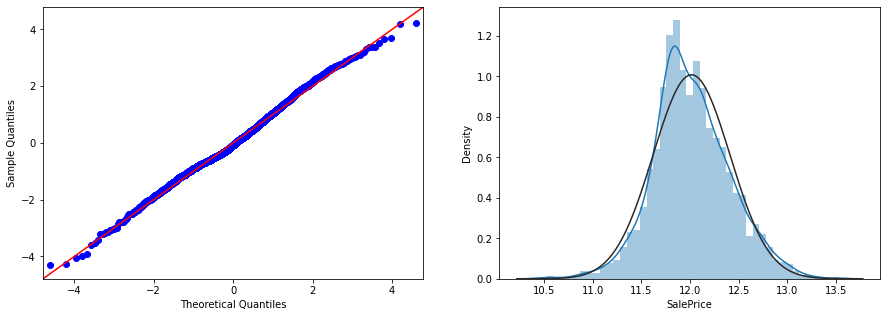

In [261]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sm.qqplot(np.log(df_all.SalePrice), stats.t, distargs=(4,),fit=True, line="45", ax=ax[0])
sns.distplot(np.log(df_all.SalePrice), kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

In [262]:
df_number = df_all.select_dtypes(exclude=[object])
df_str = df_all.select_dtypes(include=[object])

In [263]:
'''Заполняем пропущенные значения'''
df_number = fill_empty(df_number)

<ipython-input-60-f8b7897f2bc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].fillna(0)


# Производим кластеризцию по числовым признакам.<a class="anchor" id="5-bullet"></a>

In [264]:
pca = PCA(n_components=3) # сколько измерений мы хотим получить на выходе
tsne = TSNE(n_components=3, perplexity=50)
umap = UMAP(n_components=3, n_neighbors=5)

X = StandardScaler().fit_transform(df_number.drop('SalePrice', axis=1))

X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_umap = umap.fit_transform(X)

Text(0.5, 1.0, 'UMAP')

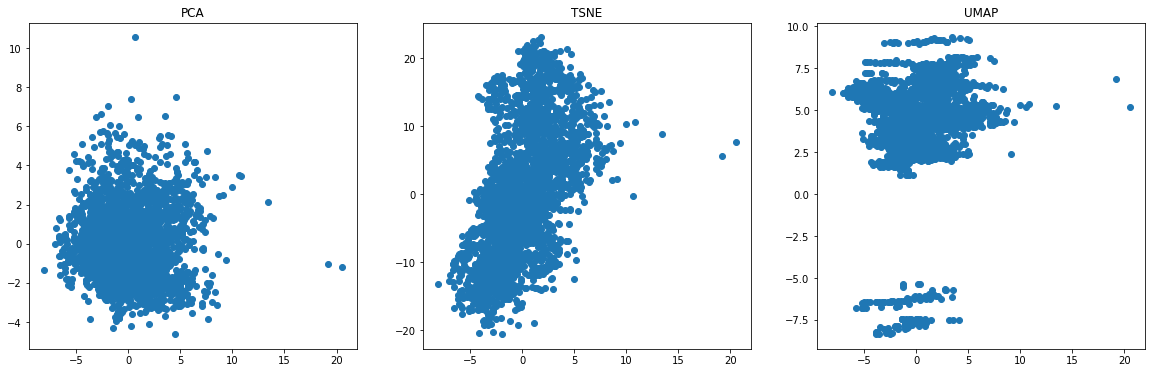

In [265]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.scatter(X_pca[:, 0], X_pca[:, 1])
ax2.scatter(X_pca[:, 0], X_tsne[:, 1])
ax3.scatter(X_pca[:, 0], X_umap[:, 1])
ax1.set_title('PCA')
ax2.set_title('TSNE')
ax3.set_title('UMAP')

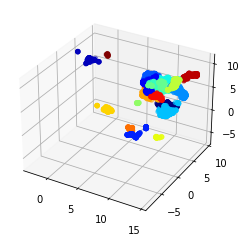

In [266]:
'''Выбираем "AgglomerativeClustering"'''
ap = AgglomerativeClustering(20)
y_ap = ap.fit_predict(X_umap)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = X_umap[:, 0]
y = X_umap[:, 1]
z = X_umap[:, 2]
print(ax.scatter(x, y, z, c=y_ap, cmap='jet'))

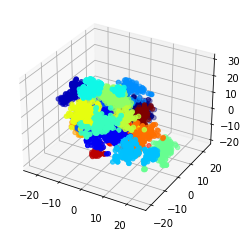

In [267]:
ap = AgglomerativeClustering(20)
x_ap = ap.fit_predict(X_tsne)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = X_tsne[:, 0]
y = X_tsne[:, 1]
z = X_tsne[:, 2]
print(ax.scatter(x, y, z, c=x_ap, cmap='jet'))

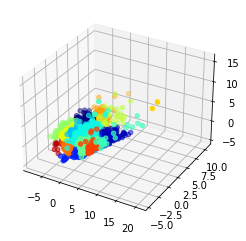

In [268]:
'''Для дальнейшей кластеризации выбираем способ "pca"'''
ap = AgglomerativeClustering(20)
z_ap = ap.fit_predict(X_pca)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]
print(ax.scatter(x, y, z, c=z_ap, cmap='jet'))

In [269]:
'''Добавляем новый признак'''
df_number['Cluster'] = z_ap
df_number = pd.concat([df_number, pd.get_dummies(df_number['Cluster'], prefix=('Cluster'))], axis=1)
df_number.drop('Cluster', axis=1, inplace=True)

<ipython-input-269-34b310012844>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_number['Cluster'] = z_ap


# Производим разбиение признаков качества<a class="anchor" id="6-bullet"></a>
## по числовым показателям

In [270]:
quality = ['Qual', 'Class','QC']
qual_feat = [i for i in df_str.columns if any(x in i for x in quality)]
df_str.drop(qual_feat, axis=1, inplace=True)
df_number = df_number.join(df_all[qual_feat])

word = ['Ex','Gd', 'TA', 'Fa', 'Po']
value = [5, 4, 3, 2, 1]
df_new_number = df_number.replace(word, value)

C:\Users\ryzhk\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Заполняем пропуски и применяем OneHotEncoding.<a class="anchor" id="7-bullet"></a>

In [271]:
new_df_all = second_concat(df_str, df_new_number)
new_df_all = OneHotEncoding(new_df_all)
new_df_all = fill_empty(new_df_all)

# Делим датасет на обучающий и валидационный.<a class="anchor" id="8-bullet"></a>

In [272]:
df_train, df_test = separate(new_df_all)

# Определяем признаки и целевую переменную.<a class="anchor" id="9-bullet"></a>

In [273]:
features = df_test.columns.to_list()
target = 'SalePrice'

# Нормализуем данные.<a class="anchor" id="10-bullet"></a>
## Логарифмируем для более точного результата.

In [274]:
df_train_X = df_train[features]
df_train_Y = df_train[target]

X, Y = df_train_X.to_numpy(), df_train_Y.to_numpy()
Y = np.log(Y)
X_test = df_test.to_numpy()

# Модель № 1: RandomForestRegressor.<a class="anchor" id="11-bullet"></a>

In [42]:
RF_1 = RandomForestRegressor()
params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 11, 12],
    'min_samples_split': [4, 5]
}
RF = GridSearchCV(
    RF_1,
    param_grid=params, 
    cv=10, # делим на 5 частей
    refit=True, # выберет самую хорошую модель и применит на тестовую
    n_jobs=4, # сколько потоков считать
    verbose=5
)

In [43]:
model_1 = RF.fit(X, Y)
print('R2= ', r2_score(Y, RF.predict(X)))
Final_RF = np.exp(RF.predict(X_test))
Final_RF

Fitting 10 folds for each of 12 candidates, totalling 120 fits
R2=  0.9750305043438523


array([130464.29112476, 165412.20848744, 178175.12024555, ...,
       169285.93505903, 108192.06265058, 212935.01008039])

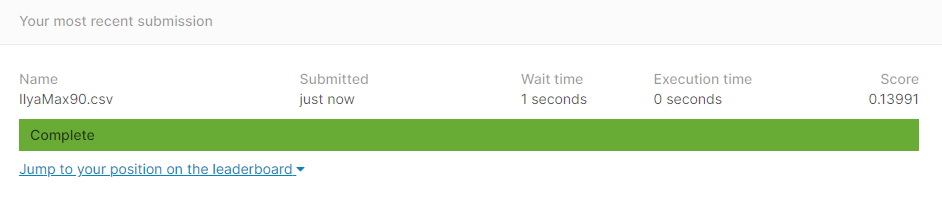

In [311]:
Image("RF_best.png")

# Модель № 2: XGBRegressor.<a class="anchor" id="12-bullet"></a>

In [88]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=3,
                       gamma=0,
                       colsample_bytree=0.7,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       objective='reg:squarederror')

In [89]:
model_2 = xgboost.fit(X, Y)
print('R2= ', r2_score(Y, xgboost.predict(X)))
Final_XGBR = np.exp(xgboost.predict(X_test))
Final_XGBR

R2=  0.97830823128321


array([127007.664, 170105.67 , 185252.95 , ..., 167680.02 , 112833.86 ,
       220662.14 ], dtype=float32)

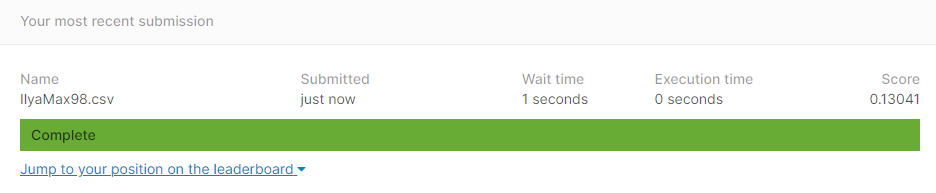

In [302]:
Image("XGBR_best.PNG")

# Модель № 3: LGBMRegressor.<a class="anchor" id="13-bullet"></a>

In [275]:
lightgbm = LGBMRegressor(objective='regression',num_leaves=4, learning_rate=0.01, 
                         n_estimators=5000,max_bin=200, bagging_fraction=0.75,
                         bagging_freq=5, bagging_seed=7,feature_fraction=0.2,
                         feature_fraction_seed=7, verbose=-1)

In [276]:
model_3 = lightgbm.fit(X, Y)
print('R2= ', r2_score(Y,lightgbm.predict(X)))
Final_LGBMR = np.exp(lightgbm.predict(X_test))
Final_LGBMR

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
R2=  0.9608239155030245


array([123963.55609937, 161164.72918032, 182617.22359159, ...,
       170730.99813951, 117283.81849907, 209328.87421486])

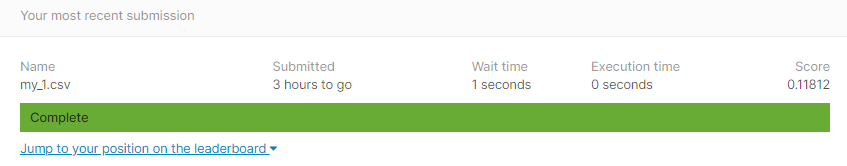

In [124]:
Image("LGBMfinal_best.PNG")

# Модель № 4: CatBoostRegressor.<a class="anchor" id="14-bullet"></a>

In [306]:
cat = CatBoostRegressor(iterations = 10000, learning_rate = .08, eval_metric = 'RMSE',
                        random_seed = 42, logging_level=  'Silent', loss_function = 'RMSE',
                        od_type = 'Iter', od_wait = 1000, one_hot_max_size = 20,
                        l2_leaf_reg = 100, depth = 3, rsm = .6,
                        random_strength = 2, bagging_temperature = 10)

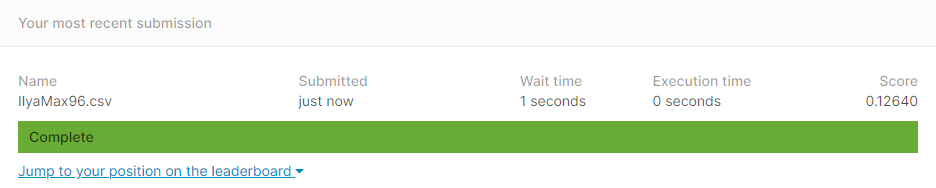

In [308]:
Image("CAT_best.PNG")

# Смотрим какие признаки внесли наибольшее вияние.<a class="anchor" id="15-bullet"></a>

In [42]:
feat = pd.DataFrame({
    'Value': model_3.feature_importances_ / 1000,
    'Feature': features
}).sort_values(by="Value", ascending=False)

C:\Users\ryzhk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


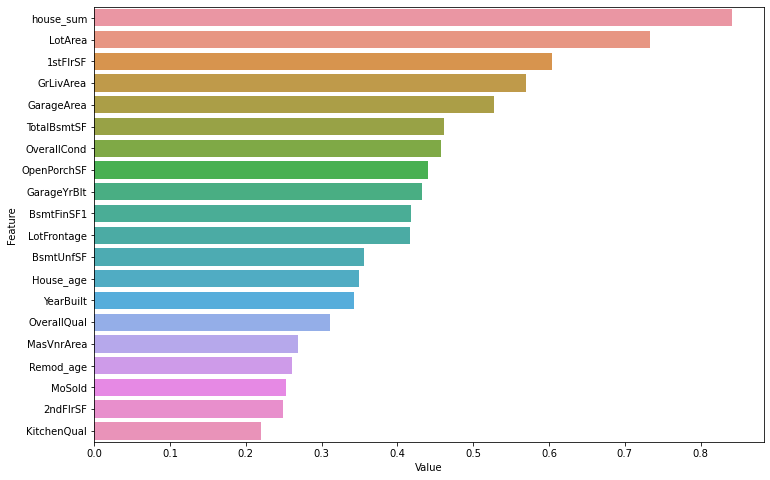

In [43]:
plt.figure(figsize=(12, 8))
sns.barplot(feat['Value'][:20],feat['Feature'][:20], orient='h')
plt.show()

# Выбираем лучшую модель и сохраняем в новый файл.<a class="anchor" id="16-bullet"></a>

In [277]:
df_test = pd.read_csv('test.csv')

In [278]:
df_test['SalePrice'] = Final_LGBMR
df_test[['Id','SalePrice']]

,Id,SalePrice
0,1461,123963.556099
1,1462,161164.729180
2,1463,182617.223592
3,1464,191651.018885
4,1465,193678.734469
...,...,...
1454,2915,84574.240916
1455,2916,81923.150963
1456,2917,170730.998140
1457,2918,117283.818499


In [279]:
df_test[['Id','SalePrice']].to_csv('my_8.csv', index=False)